# 부트스트랩


## SlipperyWalk

In [1]:
import gymnasium as gym
import numpy as np

class SlipperyWalk(gym.Env):
    def __init__(self, length):
        super().__init__()

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Discrete(length)

        self.start_state = length // 2  # 2로 나눈 몫
        self.state = self.start_state
        self.done = False
        self.truncated = False
        self.length = length
        self.P = self.set_transition()

    def set_transition(self):
        P = {}
        transition_probs = {'MOVE': 1/2, 'STAY': 1/3, 'OPPOSITE': 1/6}
        goal = self.length - 1

        for s in range(self.length):
            P[s] = {}
            for a in range(2):
                if s == 0:
                    P[s][a] = [(1.0, s, 0, True)]  # 확률, 상태, 보상, 종료 여부
                elif s == goal:
                    P[s][a] = [(1.0, s, 1, True)]
                else:
                    transitions = []
                    for transition, prob in transition_probs.items():
                        if transition == 'MOVE':
                            next_state = s + 1 if a == 1 else s - 1
                        elif transition == 'STAY':
                            next_state = s
                        elif transition == 'OPPOSITE':
                            next_state = s - 1 if a == 1 else s + 1
                        next_state = max(0, min(goal, next_state))   # 범위 제한 표현
                        reward = 1 if next_state == goal else 0      # 삼항 연산자
                        done = next_state == 0 or next_state == goal
                        transitions.append((prob, next_state, reward, done))
                    P[s][a] = transitions

        return P

    def reset(self):
        self.state = self.start_state
        self.done = False
        self.truncated = False
        self.steps = 0
        return self.state, {}

    def step(self, action):
        transitions = self.P[self.state][action]
        probs = np.array([t[0] for t in transitions])
        i = np.random.choice(np.arange(len(transitions)), p=probs)
        _, self.state, reward, self.done = transitions[i]
        self.steps += 1
        self.truncated = self.steps >= 100
        return self.state, reward, self.done, self.truncated, {}

    def render(self, mode='human'):
        grid = ['X'] + ([' '] * (self.length - 2)) + ['O']  # 리스트 연산
        grid[self.state] = 'A'
        print('|' + '|'.join(grid) + '|') # 문자열 연산

    @property
    def unwrapped(self):
        return self


환경 생성

In [2]:
env = SlipperyWalk(9)

리셋

In [3]:
env.reset()

(4, {})

왼쪽으로 한 걸음

In [4]:
env.step(0)

(3, 0, False, False, {})

그리기

In [5]:
env.render()

|X| | |A| | | | |O|


## 정책 평가

In [6]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    nS = len(P)  # 상태의 수
    prev_V = np.zeros(nS)  # ns와 크기가 같은 영(0)벡터
    while True:
        V = np.zeros_like(prev_V)  # prev_V와 모양이 같은 영벡터
        for s in range(nS):
            for prob, next_state, reward, done in P[s][pi[s]]:
                rtrn = reward + gamma * prev_V[next_state] * (not done)
                V[s] += prob * rtrn
        if np.max(np.abs(prev_V - V)) < theta: # 기존 V와 차이가 작으면 중단
            break
        prev_V = V.copy()
    return V


무조건 왼쪽으로 걷는 정책

In [7]:
LEFT, RIGHT = 0, 1
pi = {
    s: LEFT
    for s in range(env.observation_space.n)
}

평가

In [8]:
V = policy_evaluation(pi, env.P)
V

array([0.00000000e+00, 3.04878027e-04, 1.21951212e-03, 3.96341448e-03,
       1.21951217e-02, 3.68902434e-02, 1.10975609e-01, 3.33231707e-01,
       1.00000000e+00])

## 정책 반복법 

In [9]:
def policy_improvement(V, P, gamma=1.0):
    nS = len(P) 
    nA = len(P[0])  # 행동의 수
    Q = np.zeros((nS,nA))
    for s in range(nS):
        for a in range(nA):
            for prob, next_state, reward, done in P[s][a]:
                rtrn = reward + gamma * V[next_state] * (not done)
                Q[s][a] += prob * rtrn
    new_pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    return new_pi

평가된 가치를 바탕으로 정책 개선

In [10]:
improved_pi = policy_improvement(V, env.P)
improved_pi

{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0}

개선된 정책의 평가

In [11]:
improved_V = policy_evaluation(improved_pi, env.P)
improved_V

array([0.        , 0.66676829, 0.88902439, 0.96310976, 0.98780488,
       0.99603659, 0.99878049, 0.99969512, 1.        ])

정책 반복

In [13]:
def policy_iteration(env, gamma=1.0, theta=1e-10):
    pi = random_policy(env)
    P = env.unwrapped.P
    while True:
        old_pi = dict(pi)
        V = policy_evaluation(pi, P, gamma, theta)
        pi = policy_improvement(V, P, gamma)
        if old_pi == pi:
            break
    return V, pi


In [14]:
def random_policy(env):
    return {s: env.action_space.sample() 
            for s in range(env.observation_space.n)}

policy_iteration(env)

(array([0.        , 0.66676829, 0.88902439, 0.96310976, 0.98780488,
        0.99603659, 0.99878049, 0.99969512, 1.        ]),
 {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0})

### FrozenLake 환경에서 실험

In [15]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array")

def print_policy(pi, n_rows, n_cols, action_symbols):
    for i in range(n_rows):
        for j in range(n_cols):
            action = pi[i * n_cols + j]
            print(action_symbols[action], end=' ')
        print()


In [16]:
import tqdm

def count_success(pi, env):
    total_reward = 0
    for _ in tqdm.trange(100):
        state, _ = env.reset()
        terminated = False
        while not terminated:
            action = pi[state]
            state, reward, terminated, truncated, info = env.step(action)
        else:
            total_reward += reward
    return total_reward / 100


무작위 정책

In [17]:
pi = random_policy(env)
print_policy(pi, 4, 4, '←↓→↑')
count_success(pi, env)

↓ → ↑ → 
↑ ↑ ↓ ↓ 
← ← ↑ ↓ 
↑ ↓ ↑ ↓ 


100%|██████████| 100/100 [00:00<00:00, 11743.49it/s]


0.0

정책 반복으로 개선된 정책

In [18]:
V, pi = policy_iteration(env)
print_policy(pi, 4, 4, '←↓→↑')
count_success(pi, env)

← ↑ ↑ ↑ 
← ← ← ← 
↑ ↓ ← ← 
← → ↓ ← 


100%|██████████| 100/100 [00:00<00:00, 3106.52it/s]


0.82

### CliffWalking으로 실험

In [19]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
V, pi = policy_iteration(env, 0.9)
print_policy(pi, 4, 12, '↑→↓←')

→ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → 


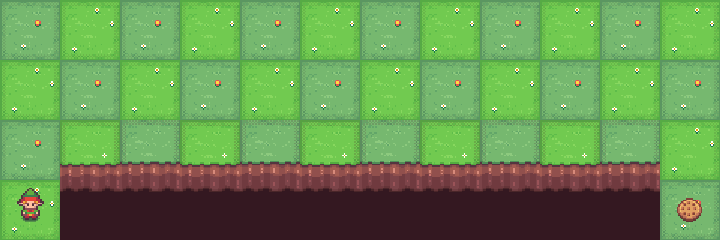

In [22]:
import imageio
from IPython.display import Image

state, _ = env.reset()
frames = []
frames.append(env.render())
terminated = False
while not terminated:
    action = pi[state]
    state, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())
filename = 'animation.gif'
imageio.mimsave(filename, frames, fps=2)
Image(filename)

## 가치 반복

In [24]:
def value_iteration(env, gamma=1.0, theta=1e-10):
    P = env.unwrapped.P
    nS = env.observation_space.n
    nA = env.action_space.n
    V = np.zeros(nS)
    while True:
        Q = np.zeros((nS, nA))
        for s in range(nS):
            for a in range(nA):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
        pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    return V, pi


In [25]:
V, pi = value_iteration(env)
print_policy(pi, 4, 12, '↑→↓←')

↑ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → 


## 퀴즈

<iframe src="https://tally.so/embed/mRR7BP?alignLeft=1&hideTitle=1&transparentBackground=1&dynamicHeight=1" loading="lazy" width="100%" height="1900" frameborder="0" marginheight="0" marginwidth="0" title="[RL] 가치"></iframe>